# Fashion Recommendation System
[Data Information]   
Data Source: https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=78   
Raw Data Type : 720x1280x24b

[Image]   
Item-Image : n장   
Model-Image : m장

[Version]   
Based Convolutional AE, 64x64x3

## 0. Setting

### Goole Drive Connecting

In [ ]:
pwd

'/content'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/Code Lion/Final'

/content/drive/MyDrive/Code Lion/Final


In [ ]:
!ls

 data  'Fashion Recommendation System0810.ipynb'   figure  'low version'


### Library Call

In [ ]:
pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 29.3 MB/s 


In [ ]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 상용 라이브러리
from glob import glob
import os
import cv2
import pandas as pd
import numpy as np
import datetime as dt
import time

# 시각화 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import plotly.graph_objects as go

# 한글 폰트 패치
matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False   

# 시각화 포맷 설정
plt.style.use("ggplot")
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.set_context("talk")

# 경고문 처리
import warnings
warnings.filterwarnings('ignore')

# sckit-learn
from sklearn.model_selection import train_test_split

# Tensorflow 라이브러리
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
import tensorflow_addons as tfa
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Input, MaxPooling2D, UpSampling2D
from keras import layers, models
from keras.utils import np_utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

### User Function Definition

In [ ]:
import os
os.getcwd()

'd:\\Fasion_Images'

In [ ]:
# root_dir = 'D:/Fasion_Images/Train/train_itemimages/Item-Image/'
# glob(f'{root_dir}/*.jpg')

In [ ]:
# -------------Image Load & Preprocessing ------------- #
# Global Constant Definition
imgR = 64
imgC = 64
channel = 3
crop_y = (250,1000)
crop_x = (40,680)
root_dir = 'D:/Fasion_Images/Train/train_itemimages/Item-Image/'

# Single Image Load
def img_read(file):
  img = cv2.imread(file)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

# Gamma Correction
def adjust_gamma(img, gamma=1.0): # 감마 보정 함수
    invGamma = 1.0 / gamma
    out = img.copy().astype(np.float)
    out = ((out / 255) ** invGamma) * 255
    return out.astype(np.uint8)

# Image Crop & Resize
def img_crop(img):
    img = img[crop_y[0]:crop_y[1], crop_x[0]:crop_x[1]]
    img = cv2.resize(img, (imgR,imgC), cv2.INTER_LINEAR)
    return img

# Load All img from folder
def load_img_folder():
    wfiles = sorted(glob(f'{root_dir}/*.jpg'))
    img_list = []
    label_list = []
    for file in wfiles:
        img = img_read(file)
        img = img_crop(img)
        img = adjust_gamma(img, 0.8)
        img_list.append(img)
        label_list.append(file.split('/')[-1])
    return np.array(img_list), label_list

# Top10 유사 이미지 시각화
def top10_visualize(img_set,top10_idx):
  fig = plt.figure()
  fig, ax = plt.subplots(2, 5, figsize=(5*3,2*3))
  plt.suptitle('Top10 Similar Images',size=20)
  k=0
  for i in range(2):
    for j in range(5):
      axis = ax[i,j]
      axis.get_xaxis().set_visible(False)
      axis.get_yaxis().set_visible(False)
      axis.imshow(img_set[top10_idx[i+j]])
      plt.axis('off')
    k += 5
  plt.show()

# -------------Image EDA & Visualization ------------- #

# plot_images
def plot_images(nRow, nCol, img_set):
  fig = plt.figure()
  fig, ax = plt.subplots(nRow, nCol, figsize=(nCol*4,nRow*4))
  k=0
  for i in range(nRow):
    for j in range(nCol):
      if nRow <= 1 : axis = ax[j]
      else:          axis = ax[i,j]
      axis.get_xaxis().set_visible(False)
      axis.get_yaxis().set_visible(False)
      axis.imshow(img_set[k+j])
      plt.axis('off')
    k += nCol
  plt.show()


# ------------- Model Function ------------- #

def Reconstruction_Error(X_test,X_pred):
  error_list = []
  for i in range(len(X_test)):
    ele = np.mean(np.power(X_test[i] - X_pred[i], 2),axis=1).mean()
    error_list.append(ele)
  return error_list

def AVGpooling(raw_feature):
  result = []
  for i in range(raw_feature.shape[0]):
    row= []
    for j in range(raw_feature.shape[-1]):
      row.append(raw_feature[i,:,:,j].mean())
    result.append(row)
  return np.array(result)

## 1. Data Load

In [ ]:
# Image DataSet Load
img_set, label_set = load_img_folder()
print('img_set.shape :',img_set.shape)
print('label_set.shape :',len(label_set))

img_set.shape : (33170, 64, 64, 3)
label_set.shape : 33170


In [ ]:
# Image Information
type(img_set), round(img_set.mean(),4)

(numpy.ndarray, 215.1971)

In [ ]:
# Label Information
type(label_set), label_set[:4]

(list,
 ['Item-Image\\0928015_B.jpg',
  'Item-Image\\0928015_F.jpg',
  'Item-Image\\0929029_B.jpg',
  'Item-Image\\0929029_F.jpg'])

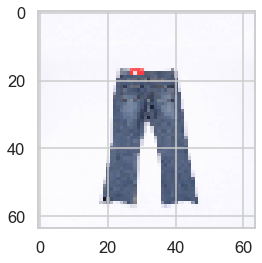

In [ ]:
# Image Sample
plt.imshow(img_set[200])

<Figure size 432x288 with 0 Axes>

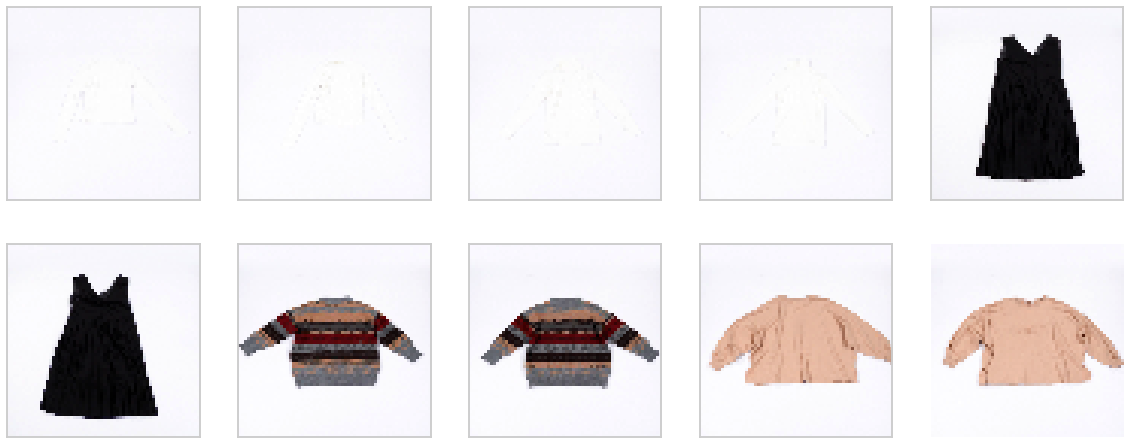

In [ ]:
# Multi Image Samples
_ = plot_images(2,5,img_set)

## 2. Data Preprocessing

In [ ]:
# Data Normalization
img_scaled = img_set / 255.0
print('Raw Image Format :',img_set.shape, img_set.mean())
print('Scaled Image Format :',img_scaled.shape, img_scaled.mean())

Raw Image Format : (33170, 64, 64, 3) 215.19705884027044
Scaled Image Format : (33170, 64, 64, 3) 0.8439100346677257


In [ ]:
# Train, Test Data Split
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(img_scaled, label_set, random_state=42, test_size=0.2, shuffle=True)
print(X_train.shape, len(y_train))
print(X_test.shape, len(y_test))

(26536, 64, 64, 3) 26536
(6634, 64, 64, 3) 6634


## 3. Convolutional Autoencoder Modeling

### Encoder

In [ ]:
# Encoder Part Modeling
tf.keras.backend.clear_session()
encoder_input = Input(shape=(imgR,imgC,channel))

L1 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
L2 = MaxPooling2D((2, 2))(L1)
L3 = Conv2D(16, (3, 3), activation='relu', padding='same')(L2)
L4 = MaxPooling2D((2, 2))(L3)
L5 = Conv2D(8, (3, 3), activation='relu', padding='same')(L4)
L6 = MaxPooling2D((2, 2))(L5)
L7 = Conv2D(8, (3, 3), activation='relu', padding='same')(L6)
L8 = MaxPooling2D((2, 2))(L7)

encoder_output = L8

In [ ]:
# Encoder Summary()
encoder = keras.Model(encoder_input, encoder_output)
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 8)         1160  

In [ ]:
pip install pydot

In [ ]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Plot Encoder Diagram
plot_model(encoder, to_file='figure/Eecoder0810.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


### Decoder

In [ ]:
# Decoder Part Modeling
decoder_input = Input(shape=(4,4,8))  # Decoder의 Input Shape는 Hard Coding이 필요함. (개선점)

L9 = Conv2D(8, (3, 3), activation='relu', padding='same')(decoder_input)
L10 = UpSampling2D((2, 2))(L9)
L11 = Conv2D(8, (3, 3), activation='relu', padding='same')(L10)
L12 = UpSampling2D((2, 2))(L11)
L13 = Conv2D(16, (3, 3), activation='relu', padding='same')(L12)
L14 = UpSampling2D((2, 2))(L13)
L15 = Conv2D(32, (3, 3), activation='sigmoid', padding='same')(L14)
L16 = UpSampling2D((2, 2))(L15)
L17 = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(L16)

decoder_output = L17

In [ ]:
# Decoder Summary()
decoder = keras.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4, 4, 8)]         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 8)           584       
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 8)          0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 8)           584       
                                                                 
 up_sampling2d_1 (UpSampling  (None, 16, 16, 8)        0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 16)        1168

In [ ]:
# Plot Decoder Diagram
plot_model(decoder, to_file='figure/Decoder0810.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


### AutoEncoder (Encoder + Decoder)

In [ ]:
# Convolutional Autoencoder Modeling
# Connecting Encoder & Decoder Part

init_input = Input(shape=(imgR,imgC,channel))
connect_input = encoder(init_input)
connect_output = decoder(connect_input)

model = keras.Model(init_input, connect_output)

In [ ]:
# Model Compile
model.compile(optimizer='Adam',loss='binary_crossentropy')

In [ ]:
# Convolutional Autoencoder Summary
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 model (Functional)          (None, 4, 4, 8)           7264      
                                                                 
 model_1 (Functional)        (None, 64, 64, 3)         7843      
                                                                 
Total params: 15,107
Trainable params: 15,107
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Plot ConvAE Diagram
plot_model(model, to_file='figure/ConvAE0810.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [ ]:
# Checkpoint Callback Function Definition
checkpoint_dir = 'Training-checkpoint/'
checkpoint_path = checkpoint_dir + 'cp-{epoch:04d}-{val_loss:.2f}.ckpt'

# 10번 에포크씩 val_loss 변화 확인- 변화 없을 시 학습 중단
patience_epoch = 15
early_stopping = EarlyStopping(monitor='val_loss', patience=patience_epoch)
cp = ModelCheckpoint(filepath=checkpoint_path, verbose=1,
                     save_weights_only=True,
                     save_best_only=True)

In [ ]:
# TQDM Tracking Conv-AE Model Training
nb_epochs = 100
batch_size = 64

start = time.time()
tqdm_callback = tfa.callbacks.TQDMProgressBar()
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size, shuffle=True,
                    callbacks=[early_stopping, cp, tqdm_callback], validation_split=0.05).history
end = time.time()

Training:   0%|           0/100 ETA: ?s,  ?epochs/s

Epoch 1/100


0/394           ETA: ?s - 

Epoch 1/100
394/394 [==============================] - ETA: 0s - loss: 0.2851
Epoch 1: val_loss improved from inf to 0.24776, saving model to Training-checkpoint\cp-0001-0.25.ckpt
394/394 [==============================] - 480s 1s/step - loss: 0.2851 - val_loss: 0.2478
Epoch 2/100


0/394           ETA: ?s - 

Epoch 2/100
394/394 [==============================] - ETA: 0s - loss: 0.2413
Epoch 2: val_loss improved from 0.24776 to 0.24116, saving model to Training-checkpoint\cp-0002-0.24.ckpt
394/394 [==============================] - 477s 1s/step - loss: 0.2413 - val_loss: 0.2412
Epoch 3/100


0/394           ETA: ?s - 

Epoch 3/100
394/394 [==============================] - ETA: 0s - loss: 0.2361
Epoch 3: val_loss improved from 0.24116 to 0.23692, saving model to Training-checkpoint\cp-0003-0.24.ckpt
394/394 [==============================] - 455s 1s/step - loss: 0.2361 - val_loss: 0.2369
Epoch 4/100


0/394           ETA: ?s - 

Epoch 4/100
394/394 [==============================] - ETA: 0s - loss: 0.2335
Epoch 4: val_loss improved from 0.23692 to 0.23459, saving model to Training-checkpoint\cp-0004-0.23.ckpt
394/394 [==============================] - 445s 1s/step - loss: 0.2335 - val_loss: 0.2346
Epoch 5/100


0/394           ETA: ?s - 

Epoch 5/100
394/394 [==============================] - ETA: 0s - loss: 0.2316
Epoch 5: val_loss improved from 0.23459 to 0.23264, saving model to Training-checkpoint\cp-0005-0.23.ckpt
394/394 [==============================] - 514s 1s/step - loss: 0.2316 - val_loss: 0.2326
Epoch 6/100


0/394           ETA: ?s - 

Epoch 6/100
394/394 [==============================] - ETA: 0s - loss: 0.2301
Epoch 6: val_loss improved from 0.23264 to 0.23183, saving model to Training-checkpoint\cp-0006-0.23.ckpt
394/394 [==============================] - 440s 1s/step - loss: 0.2301 - val_loss: 0.2318
Epoch 7/100


0/394           ETA: ?s - 

Epoch 7/100
394/394 [==============================] - ETA: 0s - loss: 0.2289
Epoch 7: val_loss improved from 0.23183 to 0.23049, saving model to Training-checkpoint\cp-0007-0.23.ckpt
394/394 [==============================] - 440s 1s/step - loss: 0.2289 - val_loss: 0.2305
Epoch 8/100


0/394           ETA: ?s - 

Epoch 8/100
394/394 [==============================] - ETA: 0s - loss: 0.2278
Epoch 8: val_loss improved from 0.23049 to 0.22872, saving model to Training-checkpoint\cp-0008-0.23.ckpt
394/394 [==============================] - 444s 1s/step - loss: 0.2278 - val_loss: 0.2287
Epoch 9/100


0/394           ETA: ?s - 

Epoch 9/100
394/394 [==============================] - ETA: 0s - loss: 0.2264
Epoch 9: val_loss improved from 0.22872 to 0.22766, saving model to Training-checkpoint\cp-0009-0.23.ckpt
394/394 [==============================] - 428s 1s/step - loss: 0.2264 - val_loss: 0.2277
Epoch 10/100


0/394           ETA: ?s - 

Epoch 10/100
394/394 [==============================] - ETA: 0s - loss: 0.2255
Epoch 10: val_loss improved from 0.22766 to 0.22688, saving model to Training-checkpoint\cp-0010-0.23.ckpt
394/394 [==============================] - 518s 1s/step - loss: 0.2255 - val_loss: 0.2269
Epoch 11/100


0/394           ETA: ?s - 

Epoch 11/100
394/394 [==============================] - ETA: 0s - loss: 0.2247
Epoch 11: val_loss improved from 0.22688 to 0.22637, saving model to Training-checkpoint\cp-0011-0.23.ckpt
394/394 [==============================] - 414s 1s/step - loss: 0.2247 - val_loss: 0.2264
Epoch 12/100


0/394           ETA: ?s - 

Epoch 12/100
394/394 [==============================] - ETA: 0s - loss: 0.2241
Epoch 12: val_loss improved from 0.22637 to 0.22586, saving model to Training-checkpoint\cp-0012-0.23.ckpt
394/394 [==============================] - 450s 1s/step - loss: 0.2241 - val_loss: 0.2259
Epoch 13/100


0/394           ETA: ?s - 

Epoch 13/100
394/394 [==============================] - ETA: 0s - loss: 0.2235
Epoch 13: val_loss improved from 0.22586 to 0.22529, saving model to Training-checkpoint\cp-0013-0.23.ckpt
394/394 [==============================] - 492s 1s/step - loss: 0.2235 - val_loss: 0.2253
Epoch 14/100


0/394           ETA: ?s - 

Epoch 14/100
394/394 [==============================] - ETA: 0s - loss: 0.2230
Epoch 14: val_loss improved from 0.22529 to 0.22464, saving model to Training-checkpoint\cp-0014-0.22.ckpt
394/394 [==============================] - 518s 1s/step - loss: 0.2230 - val_loss: 0.2246
Epoch 15/100


0/394           ETA: ?s - 

Epoch 15/100
394/394 [==============================] - ETA: 0s - loss: 0.2227
Epoch 15: val_loss improved from 0.22464 to 0.22433, saving model to Training-checkpoint\cp-0015-0.22.ckpt
394/394 [==============================] - 493s 1s/step - loss: 0.2227 - val_loss: 0.2243
Epoch 16/100


0/394           ETA: ?s - 

Epoch 16/100
394/394 [==============================] - ETA: 0s - loss: 0.2222
Epoch 16: val_loss did not improve from 0.22433
394/394 [==============================] - 513s 1s/step - loss: 0.2222 - val_loss: 0.2255
Epoch 17/100


0/394           ETA: ?s - 

Epoch 17/100
394/394 [==============================] - ETA: 0s - loss: 0.2220
Epoch 17: val_loss improved from 0.22433 to 0.22382, saving model to Training-checkpoint\cp-0017-0.22.ckpt
394/394 [==============================] - 678s 2s/step - loss: 0.2220 - val_loss: 0.2238
Epoch 18/100


0/394           ETA: ?s - 

Epoch 18/100
394/394 [==============================] - ETA: 0s - loss: 0.2216
Epoch 18: val_loss improved from 0.22382 to 0.22375, saving model to Training-checkpoint\cp-0018-0.22.ckpt
394/394 [==============================] - 1361s 3s/step - loss: 0.2216 - val_loss: 0.2238
Epoch 19/100


0/394           ETA: ?s - 

Epoch 19/100
394/394 [==============================] - ETA: 0s - loss: 0.2214
Epoch 19: val_loss improved from 0.22375 to 0.22337, saving model to Training-checkpoint\cp-0019-0.22.ckpt
394/394 [==============================] - 1053s 3s/step - loss: 0.2214 - val_loss: 0.2234
Epoch 20/100


0/394           ETA: ?s - 

Epoch 20/100
394/394 [==============================] - ETA: 0s - loss: 0.2212
Epoch 20: val_loss improved from 0.22337 to 0.22306, saving model to Training-checkpoint\cp-0020-0.22.ckpt
394/394 [==============================] - 1459s 4s/step - loss: 0.2212 - val_loss: 0.2231
Epoch 21/100


0/394           ETA: ?s - 

Epoch 21/100
394/394 [==============================] - ETA: 0s - loss: 0.2209
Epoch 21: val_loss improved from 0.22306 to 0.22276, saving model to Training-checkpoint\cp-0021-0.22.ckpt
394/394 [==============================] - 908s 2s/step - loss: 0.2209 - val_loss: 0.2228
Epoch 22/100


0/394           ETA: ?s - 

Epoch 22/100
394/394 [==============================] - ETA: 0s - loss: 0.2208
Epoch 22: val_loss improved from 0.22276 to 0.22256, saving model to Training-checkpoint\cp-0022-0.22.ckpt
394/394 [==============================] - 408s 1s/step - loss: 0.2208 - val_loss: 0.2226
Epoch 23/100


0/394           ETA: ?s - 

Epoch 23/100
394/394 [==============================] - ETA: 0s - loss: 0.2205
Epoch 23: val_loss improved from 0.22256 to 0.22249, saving model to Training-checkpoint\cp-0023-0.22.ckpt
394/394 [==============================] - 397s 1s/step - loss: 0.2205 - val_loss: 0.2225
Epoch 24/100


0/394           ETA: ?s - 

Epoch 24/100
394/394 [==============================] - ETA: 0s - loss: 0.2204
Epoch 24: val_loss did not improve from 0.22249
394/394 [==============================] - 406s 1s/step - loss: 0.2204 - val_loss: 0.2229
Epoch 25/100


0/394           ETA: ?s - 

Epoch 25/100
394/394 [==============================] - ETA: 0s - loss: 0.2202
Epoch 25: val_loss did not improve from 0.22249
394/394 [==============================] - 409s 1s/step - loss: 0.2202 - val_loss: 0.2228
Epoch 26/100


0/394           ETA: ?s - 

Epoch 26/100
394/394 [==============================] - ETA: 0s - loss: 0.2201
Epoch 26: val_loss improved from 0.22249 to 0.22220, saving model to Training-checkpoint\cp-0026-0.22.ckpt
394/394 [==============================] - 404s 1s/step - loss: 0.2201 - val_loss: 0.2222
Epoch 27/100


0/394           ETA: ?s - 

Epoch 27/100
394/394 [==============================] - ETA: 0s - loss: 0.2197
Epoch 27: val_loss did not improve from 0.22220
394/394 [==============================] - 401s 1s/step - loss: 0.2197 - val_loss: 0.2228
Epoch 28/100


0/394           ETA: ?s - 

Epoch 28/100
394/394 [==============================] - ETA: 0s - loss: 0.2197
Epoch 28: val_loss improved from 0.22220 to 0.22188, saving model to Training-checkpoint\cp-0028-0.22.ckpt
394/394 [==============================] - 381s 967ms/step - loss: 0.2197 - val_loss: 0.2219
Epoch 29/100


0/394           ETA: ?s - 

Epoch 29/100
394/394 [==============================] - ETA: 0s - loss: 0.2194
Epoch 29: val_loss improved from 0.22188 to 0.22118, saving model to Training-checkpoint\cp-0029-0.22.ckpt
394/394 [==============================] - 392s 995ms/step - loss: 0.2194 - val_loss: 0.2212
Epoch 30/100


0/394           ETA: ?s - 

Epoch 30/100
394/394 [==============================] - ETA: 0s - loss: 0.2193
Epoch 30: val_loss did not improve from 0.22118
394/394 [==============================] - 397s 1s/step - loss: 0.2193 - val_loss: 0.2225
Epoch 31/100


0/394           ETA: ?s - 

Epoch 31/100
394/394 [==============================] - ETA: 0s - loss: 0.2192
Epoch 31: val_loss did not improve from 0.22118
394/394 [==============================] - 362s 918ms/step - loss: 0.2192 - val_loss: 0.2212
Epoch 32/100


0/394           ETA: ?s - 

Epoch 32/100
394/394 [==============================] - ETA: 0s - loss: 0.2191
Epoch 32: val_loss did not improve from 0.22118
394/394 [==============================] - 400s 1s/step - loss: 0.2191 - val_loss: 0.2214
Epoch 33/100


0/394           ETA: ?s - 

Epoch 33/100
394/394 [==============================] - ETA: 0s - loss: 0.2189
Epoch 33: val_loss improved from 0.22118 to 0.22082, saving model to Training-checkpoint\cp-0033-0.22.ckpt
394/394 [==============================] - 404s 1s/step - loss: 0.2189 - val_loss: 0.2208
Epoch 34/100


0/394           ETA: ?s - 

Epoch 34/100
394/394 [==============================] - ETA: 0s - loss: 0.2188
Epoch 34: val_loss did not improve from 0.22082
394/394 [==============================] - 417s 1s/step - loss: 0.2188 - val_loss: 0.2209
Epoch 35/100


0/394           ETA: ?s - 

Epoch 35/100
394/394 [==============================] - ETA: 0s - loss: 0.2187
Epoch 35: val_loss improved from 0.22082 to 0.22048, saving model to Training-checkpoint\cp-0035-0.22.ckpt
394/394 [==============================] - 417s 1s/step - loss: 0.2187 - val_loss: 0.2205
Epoch 36/100


0/394           ETA: ?s - 

Epoch 36/100
394/394 [==============================] - ETA: 0s - loss: 0.2186
Epoch 36: val_loss did not improve from 0.22048
394/394 [==============================] - 414s 1s/step - loss: 0.2186 - val_loss: 0.2217
Epoch 37/100


0/394           ETA: ?s - 

Epoch 37/100
394/394 [==============================] - ETA: 0s - loss: 0.2183
Epoch 37: val_loss improved from 0.22048 to 0.22035, saving model to Training-checkpoint\cp-0037-0.22.ckpt
394/394 [==============================] - 415s 1s/step - loss: 0.2183 - val_loss: 0.2203
Epoch 38/100


0/394           ETA: ?s - 

Epoch 38/100
394/394 [==============================] - ETA: 0s - loss: 0.2184
Epoch 38: val_loss did not improve from 0.22035
394/394 [==============================] - 407s 1s/step - loss: 0.2184 - val_loss: 0.2205
Epoch 39/100


0/394           ETA: ?s - 

Epoch 39/100
394/394 [==============================] - ETA: 0s - loss: 0.2181
Epoch 39: val_loss improved from 0.22035 to 0.22010, saving model to Training-checkpoint\cp-0039-0.22.ckpt
394/394 [==============================] - 400s 1s/step - loss: 0.2181 - val_loss: 0.2201
Epoch 40/100


0/394           ETA: ?s - 

Epoch 40/100
394/394 [==============================] - ETA: 0s - loss: 0.2182
Epoch 40: val_loss improved from 0.22010 to 0.22008, saving model to Training-checkpoint\cp-0040-0.22.ckpt
394/394 [==============================] - 425s 1s/step - loss: 0.2182 - val_loss: 0.2201
Epoch 41/100


0/394           ETA: ?s - 

Epoch 41/100
394/394 [==============================] - ETA: 0s - loss: 0.2180
Epoch 41: val_loss did not improve from 0.22008
394/394 [==============================] - 372s 943ms/step - loss: 0.2180 - val_loss: 0.2204
Epoch 42/100


0/394           ETA: ?s - 

Epoch 42/100
394/394 [==============================] - ETA: 0s - loss: 0.2180
Epoch 42: val_loss did not improve from 0.22008
394/394 [==============================] - 337s 855ms/step - loss: 0.2180 - val_loss: 0.2202
Epoch 43/100


0/394           ETA: ?s - 

Epoch 43/100
394/394 [==============================] - ETA: 0s - loss: 0.2179
Epoch 43: val_loss did not improve from 0.22008
394/394 [==============================] - 336s 852ms/step - loss: 0.2179 - val_loss: 0.2202
Epoch 44/100


0/394           ETA: ?s - 

Epoch 44/100
394/394 [==============================] - ETA: 0s - loss: 0.2177
Epoch 44: val_loss did not improve from 0.22008
394/394 [==============================] - 422s 1s/step - loss: 0.2177 - val_loss: 0.2206
Epoch 45/100


0/394           ETA: ?s - 

Epoch 45/100
394/394 [==============================] - ETA: 0s - loss: 0.2176
Epoch 45: val_loss improved from 0.22008 to 0.21963, saving model to Training-checkpoint\cp-0045-0.22.ckpt
394/394 [==============================] - 382s 969ms/step - loss: 0.2176 - val_loss: 0.2196
Epoch 46/100


0/394           ETA: ?s - 

Epoch 46/100
394/394 [==============================] - ETA: 0s - loss: 0.2176
Epoch 46: val_loss improved from 0.21963 to 0.21960, saving model to Training-checkpoint\cp-0046-0.22.ckpt
394/394 [==============================] - 410s 1s/step - loss: 0.2176 - val_loss: 0.2196
Epoch 47/100


0/394           ETA: ?s - 

Epoch 47/100
394/394 [==============================] - ETA: 0s - loss: 0.2175
Epoch 47: val_loss did not improve from 0.21960
394/394 [==============================] - 381s 966ms/step - loss: 0.2175 - val_loss: 0.2197
Epoch 48/100


0/394           ETA: ?s - 

Epoch 48/100
394/394 [==============================] - ETA: 0s - loss: 0.2175
Epoch 48: val_loss did not improve from 0.21960
394/394 [==============================] - 392s 995ms/step - loss: 0.2175 - val_loss: 0.2200
Epoch 49/100


0/394           ETA: ?s - 

Epoch 49/100
394/394 [==============================] - ETA: 0s - loss: 0.2173
Epoch 49: val_loss did not improve from 0.21960
394/394 [==============================] - 417s 1s/step - loss: 0.2173 - val_loss: 0.2201
Epoch 50/100


0/394           ETA: ?s - 

Epoch 50/100
394/394 [==============================] - ETA: 0s - loss: 0.2173
Epoch 50: val_loss did not improve from 0.21960
394/394 [==============================] - 406s 1s/step - loss: 0.2173 - val_loss: 0.2199
Epoch 51/100


0/394           ETA: ?s - 

Epoch 51/100
394/394 [==============================] - ETA: 0s - loss: 0.2172
Epoch 51: val_loss did not improve from 0.21960
394/394 [==============================] - 403s 1s/step - loss: 0.2172 - val_loss: 0.2202
Epoch 52/100


0/394           ETA: ?s - 

Epoch 52/100
394/394 [==============================] - ETA: 0s - loss: 0.2171
Epoch 52: val_loss improved from 0.21960 to 0.21916, saving model to Training-checkpoint\cp-0052-0.22.ckpt
394/394 [==============================] - 407s 1s/step - loss: 0.2171 - val_loss: 0.2192
Epoch 53/100


0/394           ETA: ?s - 

Epoch 53/100
394/394 [==============================] - ETA: 0s - loss: 0.2171
Epoch 53: val_loss did not improve from 0.21916
394/394 [==============================] - 377s 958ms/step - loss: 0.2171 - val_loss: 0.2193
Epoch 54/100


0/394           ETA: ?s - 

Epoch 54/100
394/394 [==============================] - ETA: 0s - loss: 0.2170
Epoch 54: val_loss did not improve from 0.21916
394/394 [==============================] - 416s 1s/step - loss: 0.2170 - val_loss: 0.2192
Epoch 55/100


0/394           ETA: ?s - 

Epoch 55/100
394/394 [==============================] - ETA: 0s - loss: 0.2169
Epoch 55: val_loss did not improve from 0.21916
394/394 [==============================] - 409s 1s/step - loss: 0.2169 - val_loss: 0.2193
Epoch 56/100


0/394           ETA: ?s - 

Epoch 56/100
394/394 [==============================] - ETA: 0s - loss: 0.2170
Epoch 56: val_loss improved from 0.21916 to 0.21885, saving model to Training-checkpoint\cp-0056-0.22.ckpt
394/394 [==============================] - 373s 946ms/step - loss: 0.2170 - val_loss: 0.2189
Epoch 57/100


0/394           ETA: ?s - 

Epoch 57/100
394/394 [==============================] - ETA: 0s - loss: 0.2168
Epoch 57: val_loss did not improve from 0.21885
394/394 [==============================] - 392s 996ms/step - loss: 0.2168 - val_loss: 0.2189
Epoch 58/100


0/394           ETA: ?s - 

Epoch 58/100
394/394 [==============================] - ETA: 0s - loss: 0.2167
Epoch 58: val_loss did not improve from 0.21885
394/394 [==============================] - 414s 1s/step - loss: 0.2167 - val_loss: 0.2190
Epoch 59/100


0/394           ETA: ?s - 

Epoch 59/100
394/394 [==============================] - ETA: 0s - loss: 0.2167
Epoch 59: val_loss improved from 0.21885 to 0.21881, saving model to Training-checkpoint\cp-0059-0.22.ckpt
394/394 [==============================] - 370s 938ms/step - loss: 0.2167 - val_loss: 0.2188
Epoch 60/100


0/394           ETA: ?s - 

Epoch 60/100
394/394 [==============================] - ETA: 0s - loss: 0.2166
Epoch 60: val_loss improved from 0.21881 to 0.21874, saving model to Training-checkpoint\cp-0060-0.22.ckpt
394/394 [==============================] - 337s 855ms/step - loss: 0.2166 - val_loss: 0.2187
Epoch 61/100


0/394           ETA: ?s - 

Epoch 61/100
394/394 [==============================] - ETA: 0s - loss: 0.2166
Epoch 61: val_loss did not improve from 0.21874
394/394 [==============================] - 405s 1s/step - loss: 0.2166 - val_loss: 0.2190
Epoch 62/100


0/394           ETA: ?s - 

Epoch 62/100
394/394 [==============================] - ETA: 0s - loss: 0.2164
Epoch 62: val_loss did not improve from 0.21874
394/394 [==============================] - 413s 1s/step - loss: 0.2164 - val_loss: 0.2191
Epoch 63/100


0/394           ETA: ?s - 

Epoch 63/100
394/394 [==============================] - ETA: 0s - loss: 0.2165
Epoch 63: val_loss did not improve from 0.21874
394/394 [==============================] - 409s 1s/step - loss: 0.2165 - val_loss: 0.2189
Epoch 64/100


0/394           ETA: ?s - 

Epoch 64/100
394/394 [==============================] - ETA: 0s - loss: 0.2164
Epoch 64: val_loss did not improve from 0.21874
394/394 [==============================] - 413s 1s/step - loss: 0.2164 - val_loss: 0.2194
Epoch 65/100


0/394           ETA: ?s - 

Epoch 65/100
394/394 [==============================] - ETA: 0s - loss: 0.2163
Epoch 65: val_loss improved from 0.21874 to 0.21835, saving model to Training-checkpoint\cp-0065-0.22.ckpt
394/394 [==============================] - 419s 1s/step - loss: 0.2163 - val_loss: 0.2184
Epoch 66/100


0/394           ETA: ?s - 

Epoch 66/100
394/394 [==============================] - ETA: 0s - loss: 0.2164
Epoch 66: val_loss did not improve from 0.21835
394/394 [==============================] - 412s 1s/step - loss: 0.2164 - val_loss: 0.2193
Epoch 67/100


0/394           ETA: ?s - 

Epoch 67/100
394/394 [==============================] - ETA: 0s - loss: 0.2162
Epoch 67: val_loss improved from 0.21835 to 0.21828, saving model to Training-checkpoint\cp-0067-0.22.ckpt
394/394 [==============================] - 370s 938ms/step - loss: 0.2162 - val_loss: 0.2183
Epoch 68/100


0/394           ETA: ?s - 

Epoch 68/100
394/394 [==============================] - ETA: 0s - loss: 0.2162
Epoch 68: val_loss improved from 0.21828 to 0.21823, saving model to Training-checkpoint\cp-0068-0.22.ckpt
394/394 [==============================] - 338s 858ms/step - loss: 0.2162 - val_loss: 0.2182
Epoch 69/100


0/394           ETA: ?s - 

Epoch 69/100
394/394 [==============================] - ETA: 0s - loss: 0.2162
Epoch 69: val_loss did not improve from 0.21823
394/394 [==============================] - 336s 853ms/step - loss: 0.2162 - val_loss: 0.2186
Epoch 70/100


0/394           ETA: ?s - 

Epoch 70/100
394/394 [==============================] - ETA: 0s - loss: 0.2161
Epoch 70: val_loss improved from 0.21823 to 0.21817, saving model to Training-checkpoint\cp-0070-0.22.ckpt
394/394 [==============================] - 337s 855ms/step - loss: 0.2161 - val_loss: 0.2182
Epoch 71/100


0/394           ETA: ?s - 

Epoch 71/100
394/394 [==============================] - ETA: 0s - loss: 0.2161
Epoch 71: val_loss improved from 0.21817 to 0.21811, saving model to Training-checkpoint\cp-0071-0.22.ckpt
394/394 [==============================] - 1459s 4s/step - loss: 0.2161 - val_loss: 0.2181
Epoch 72/100


0/394           ETA: ?s - 

Epoch 72/100
394/394 [==============================] - ETA: 0s - loss: 0.2160
Epoch 72: val_loss did not improve from 0.21811
394/394 [==============================] - 482s 1s/step - loss: 0.2160 - val_loss: 0.2182
Epoch 73/100


0/394           ETA: ?s - 

Epoch 73/100
394/394 [==============================] - ETA: 0s - loss: 0.2159
Epoch 73: val_loss improved from 0.21811 to 0.21794, saving model to Training-checkpoint\cp-0073-0.22.ckpt
394/394 [==============================] - 414s 1s/step - loss: 0.2159 - val_loss: 0.2179
Epoch 74/100


0/394           ETA: ?s - 

Epoch 74/100
394/394 [==============================] - ETA: 0s - loss: 0.2159
Epoch 74: val_loss did not improve from 0.21794
394/394 [==============================] - 382s 969ms/step - loss: 0.2159 - val_loss: 0.2181
Epoch 75/100


0/394           ETA: ?s - 

Epoch 75/100
394/394 [==============================] - ETA: 0s - loss: 0.2159
Epoch 75: val_loss did not improve from 0.21794
394/394 [==============================] - 414s 1s/step - loss: 0.2159 - val_loss: 0.2185
Epoch 76/100


0/394           ETA: ?s - 

Epoch 76/100
394/394 [==============================] - ETA: 0s - loss: 0.2159
Epoch 76: val_loss did not improve from 0.21794
394/394 [==============================] - 384s 974ms/step - loss: 0.2159 - val_loss: 0.2183
Epoch 77/100


0/394           ETA: ?s - 

Epoch 77/100
394/394 [==============================] - ETA: 0s - loss: 0.2158
Epoch 77: val_loss improved from 0.21794 to 0.21786, saving model to Training-checkpoint\cp-0077-0.22.ckpt
394/394 [==============================] - 421s 1s/step - loss: 0.2158 - val_loss: 0.2179
Epoch 78/100


0/394           ETA: ?s - 

Epoch 78/100
394/394 [==============================] - ETA: 0s - loss: 0.2157
Epoch 78: val_loss did not improve from 0.21786
394/394 [==============================] - 418s 1s/step - loss: 0.2157 - val_loss: 0.2180
Epoch 79/100


0/394           ETA: ?s - 

Epoch 79/100
394/394 [==============================] - ETA: 0s - loss: 0.2158
Epoch 79: val_loss did not improve from 0.21786
394/394 [==============================] - 414s 1s/step - loss: 0.2158 - val_loss: 0.2193
Epoch 80/100


0/394           ETA: ?s - 

Epoch 80/100
394/394 [==============================] - ETA: 0s - loss: 0.2158
Epoch 80: val_loss improved from 0.21786 to 0.21781, saving model to Training-checkpoint\cp-0080-0.22.ckpt
394/394 [==============================] - 410s 1s/step - loss: 0.2158 - val_loss: 0.2178
Epoch 81/100


0/394           ETA: ?s - 

Epoch 81/100
394/394 [==============================] - ETA: 0s - loss: 0.2156
Epoch 81: val_loss improved from 0.21781 to 0.21769, saving model to Training-checkpoint\cp-0081-0.22.ckpt
394/394 [==============================] - 371s 941ms/step - loss: 0.2156 - val_loss: 0.2177
Epoch 82/100


0/394           ETA: ?s - 

Epoch 82/100
394/394 [==============================] - ETA: 0s - loss: 0.2157
Epoch 82: val_loss did not improve from 0.21769
394/394 [==============================] - 417s 1s/step - loss: 0.2157 - val_loss: 0.2181
Epoch 83/100


0/394           ETA: ?s - 

Epoch 83/100
394/394 [==============================] - ETA: 0s - loss: 0.2156
Epoch 83: val_loss improved from 0.21769 to 0.21758, saving model to Training-checkpoint\cp-0083-0.22.ckpt
394/394 [==============================] - 410s 1s/step - loss: 0.2156 - val_loss: 0.2176
Epoch 84/100


0/394           ETA: ?s - 

Epoch 84/100
394/394 [==============================] - ETA: 0s - loss: 0.2155
Epoch 84: val_loss did not improve from 0.21758
394/394 [==============================] - 416s 1s/step - loss: 0.2155 - val_loss: 0.2176
Epoch 85/100


0/394           ETA: ?s - 

Epoch 85/100
394/394 [==============================] - ETA: 0s - loss: 0.2156
Epoch 85: val_loss improved from 0.21758 to 0.21749, saving model to Training-checkpoint\cp-0085-0.22.ckpt
394/394 [==============================] - 413s 1s/step - loss: 0.2156 - val_loss: 0.2175
Epoch 86/100


0/394           ETA: ?s - 

Epoch 86/100
394/394 [==============================] - ETA: 0s - loss: 0.2155
Epoch 86: val_loss did not improve from 0.21749
394/394 [==============================] - 415s 1s/step - loss: 0.2155 - val_loss: 0.2190
Epoch 87/100


0/394           ETA: ?s - 

Epoch 87/100
394/394 [==============================] - ETA: 0s - loss: 0.2154
Epoch 87: val_loss improved from 0.21749 to 0.21748, saving model to Training-checkpoint\cp-0087-0.22.ckpt
394/394 [==============================] - 414s 1s/step - loss: 0.2154 - val_loss: 0.2175
Epoch 88/100


0/394           ETA: ?s - 

Epoch 88/100
394/394 [==============================] - ETA: 0s - loss: 0.2154
Epoch 88: val_loss did not improve from 0.21748
394/394 [==============================] - 415s 1s/step - loss: 0.2154 - val_loss: 0.2175
Epoch 89/100


0/394           ETA: ?s - 

Epoch 89/100
394/394 [==============================] - ETA: 0s - loss: 0.2154
Epoch 89: val_loss improved from 0.21748 to 0.21740, saving model to Training-checkpoint\cp-0089-0.22.ckpt
394/394 [==============================] - 409s 1s/step - loss: 0.2154 - val_loss: 0.2174
Epoch 90/100


0/394           ETA: ?s - 

Epoch 90/100
394/394 [==============================] - ETA: 0s - loss: 0.2154
Epoch 90: val_loss improved from 0.21740 to 0.21737, saving model to Training-checkpoint\cp-0090-0.22.ckpt
394/394 [==============================] - 405s 1s/step - loss: 0.2154 - val_loss: 0.2174
Epoch 91/100


0/394           ETA: ?s - 

Epoch 91/100
394/394 [==============================] - ETA: 0s - loss: 0.2153
Epoch 91: val_loss did not improve from 0.21737
394/394 [==============================] - 395s 1s/step - loss: 0.2153 - val_loss: 0.2175
Epoch 92/100


0/394           ETA: ?s - 

Epoch 92/100
394/394 [==============================] - ETA: 0s - loss: 0.2153
Epoch 92: val_loss did not improve from 0.21737
394/394 [==============================] - 409s 1s/step - loss: 0.2153 - val_loss: 0.2174
Epoch 93/100


0/394           ETA: ?s - 

Epoch 93/100
394/394 [==============================] - ETA: 0s - loss: 0.2153
Epoch 93: val_loss improved from 0.21737 to 0.21734, saving model to Training-checkpoint\cp-0093-0.22.ckpt
394/394 [==============================] - 410s 1s/step - loss: 0.2153 - val_loss: 0.2173
Epoch 94/100


0/394           ETA: ?s - 

Epoch 94/100
394/394 [==============================] - ETA: 0s - loss: 0.2152
Epoch 94: val_loss did not improve from 0.21734
394/394 [==============================] - 412s 1s/step - loss: 0.2152 - val_loss: 0.2176
Epoch 95/100


0/394           ETA: ?s - 

Epoch 95/100
394/394 [==============================] - ETA: 0s - loss: 0.2154
Epoch 95: val_loss improved from 0.21734 to 0.21724, saving model to Training-checkpoint\cp-0095-0.22.ckpt
394/394 [==============================] - 377s 957ms/step - loss: 0.2154 - val_loss: 0.2172
Epoch 96/100


0/394           ETA: ?s - 

Epoch 96/100
394/394 [==============================] - ETA: 0s - loss: 0.2152
Epoch 96: val_loss improved from 0.21724 to 0.21718, saving model to Training-checkpoint\cp-0096-0.22.ckpt
394/394 [==============================] - 413s 1s/step - loss: 0.2152 - val_loss: 0.2172
Epoch 97/100


0/394           ETA: ?s - 

Epoch 97/100
394/394 [==============================] - ETA: 0s - loss: 0.2151
Epoch 97: val_loss did not improve from 0.21718
394/394 [==============================] - 378s 960ms/step - loss: 0.2151 - val_loss: 0.2174
Epoch 98/100


0/394           ETA: ?s - 

Epoch 98/100
394/394 [==============================] - ETA: 0s - loss: 0.2151
Epoch 98: val_loss did not improve from 0.21718
394/394 [==============================] - 416s 1s/step - loss: 0.2151 - val_loss: 0.2174
Epoch 99/100


0/394           ETA: ?s - 

Epoch 99/100
394/394 [==============================] - ETA: 0s - loss: 0.2151
Epoch 99: val_loss improved from 0.21718 to 0.21711, saving model to Training-checkpoint\cp-0099-0.22.ckpt
394/394 [==============================] - 414s 1s/step - loss: 0.2151 - val_loss: 0.2171
Epoch 100/100


0/394           ETA: ?s - 

Epoch 100/100
394/394 [==============================] - ETA: 0s - loss: 0.2151
Epoch 100: val_loss did not improve from 0.21711
394/394 [==============================] - 417s 1s/step - loss: 0.2151 - val_loss: 0.2173


In [ ]:
# Print Training Time
train_time = end-start
result = dt.timedelta(seconds=train_time)
print('Training Time :',str(result).split('.')[0])

Training Time : 12:41:57


In [ ]:
# Training History DataFrame
df_hist = pd.DataFrame(history)
df_hist.tail()

,loss,val_loss
95,0.215168,0.217177
96,0.215134,0.217394
97,0.215113,0.217406
98,0.215106,0.217107
99,0.215111,0.217343


In [ ]:
# Best Estimator
df_hist.sort_values(by='val_loss').head(1)

,loss,val_loss
98,0.215106,0.217107


In [ ]:
# Save Model
# Encoder Part Save
encoder.save('model_save/Encoder_0810/')

# Decoder Part Save
decoder.save('model_save/Decoder_0810/')

# Convolutional Autoencoder Model Save
model.save('model_save/ConvAE_0810/')

INFO:tensorflow:Assets written to: model_save/Encoder_0810/assets


INFO:tensorflow:Assets written to: model_save/Encoder_0810/assets


INFO:tensorflow:Assets written to: model_save/Decoder_0810/assets


INFO:tensorflow:Assets written to: model_save/Decoder_0810/assets


INFO:tensorflow:Assets written to: model_save/ConvAE_0810/assets


INFO:tensorflow:Assets written to: model_save/ConvAE_0810/assets


In [ ]:
# Load Model
encoder = keras.models.load_model('model_save/Encoder_0810/')
decoder = keras.models.load_model('model_save/Decoder_0810/')
model = keras.models.load_model('model_save/ConvAE_0810/')

## 4. Performance Evaluation

In [ ]:
# Loss Learning Curve
plt.figure(figsize=(8,6))
plt.title('Loss Learning Curve')
plt.plot(df_hist.loss, label='loss', color='black', linewidth=2.0)
plt.plot(df_hist.val_loss, label='val_loss', color='green', linewidth=2.0)
plt.axvline(x=df_hist.shape[0]-patience_epoch, color='r', linestyle='--',label='best epoch')
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend(['Training Loss', 'Validation Loss', 'Saturation epoch'], fontsize=14)
plt.show()

<Figure size 432x288 with 0 Axes>

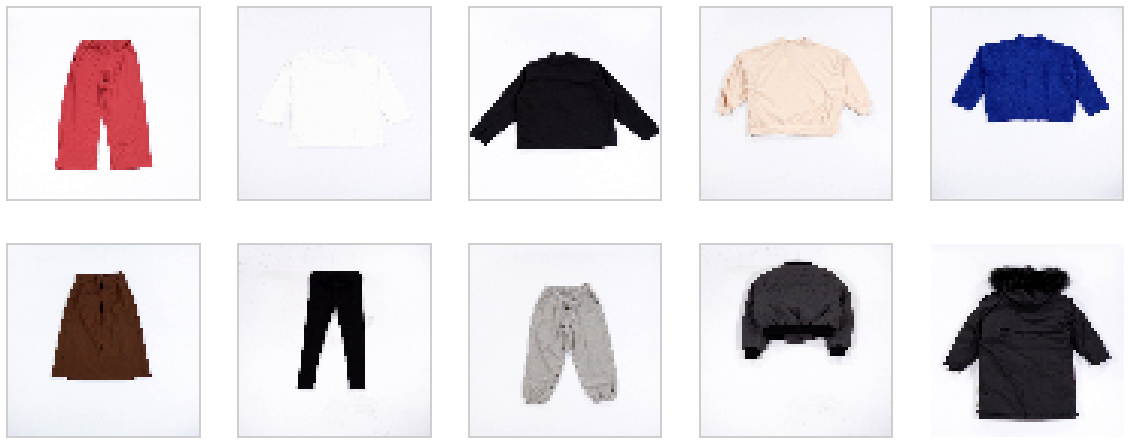

In [ ]:
# Test Image Samples
_ = plot_images(2,5,X_test)

<Figure size 432x288 with 0 Axes>

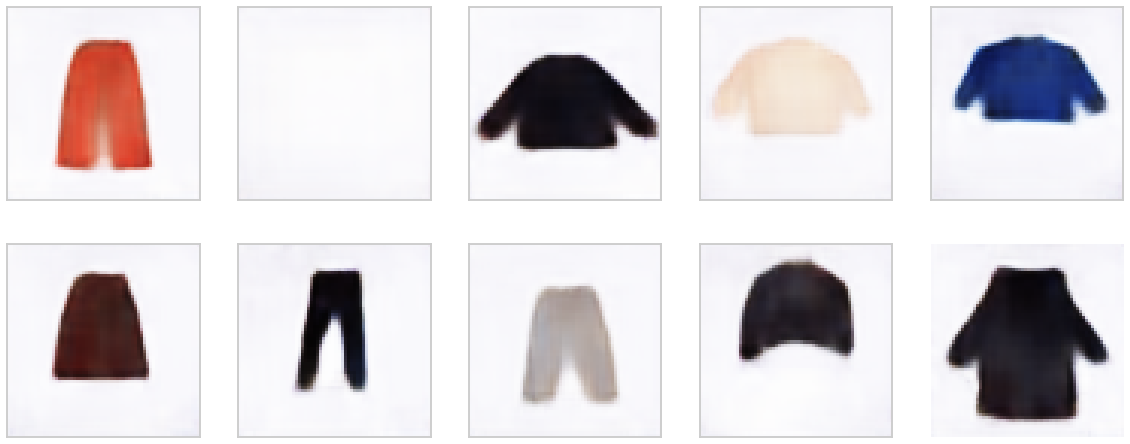

In [ ]:
# Prediction Image Samples
_ = plot_images(2,5,X_pred)

In [ ]:
# Test Data Evaluation
test_loss = model.evaluate(X_test,X_test)
print('test loss :',np.round(test_loss,4))

208/208 [==============================] - 31s 129ms/step - loss: 0.2166
test loss : 0.2166


In [ ]:
# Test Data Prediction(Reconstruction)
X_pred = model.predict(X_test)
X_pred.shape,round(X_pred.mean(),4)

208/208 [==============================] - 28s 133ms/step


((6634, 64, 64, 3), 0.8452)

In [ ]:
# Reconstruction Error 
X_error = Reconstruction_Error(X_test,X_pred)
len(X_error), type(X_error)

(6634, list)

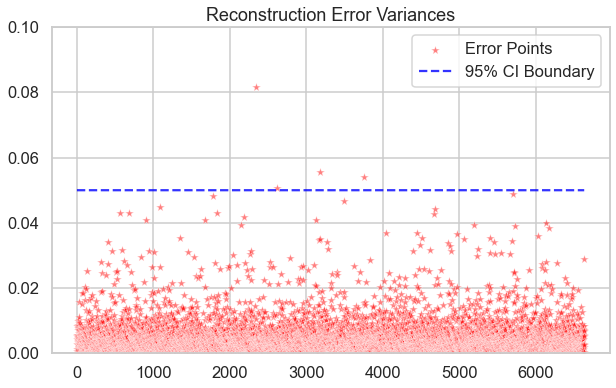

In [ ]:
# Reconstruction Error Visaulization
X_loop = np.arange(len(X_error))
boundary = 0.05

plt.figure(figsize=(10,6))
sns.scatterplot(X_loop, X_error, color = 'red', alpha=0.5, marker='*', label='Error Points')
sns.lineplot(X_loop, boundary, color='blue', linestyle='--', label='95% CI Boundary', alpha=0.8)
plt.title('Reconstruction Error Variances', size=18)
plt.legend(loc="upper right")
plt.ylim(0.00,0.10)
plt.show()

## 5. Latent Space Projection

In [ ]:
# Raw Latent Feature
raw_feature = encoder.predict(img_scaled)
raw_feature.shape, type(raw_feature)

1037/1037 [==============================] - 79s 75ms/step


((33170, 4, 4, 8), numpy.ndarray)

In [ ]:
# Deep Compact Latent 8 Features 
latent_feature = AVGpooling(raw_feature)
latent_feature.shape, type(latent_feature)

((33170, 8), numpy.ndarray)

In [ ]:
# Latent Feature DataFrame
comp_list = ['comp1','comp2','comp3','comp4','comp5','comp6','comp7','comp8','label']
df = pd.DataFrame(latent_feature)
df = pd.concat([df,pd.Series(label_set)],axis=1)
df.columns = comp_list
print('df.shape :',df.shape)
df.head()

df.shape : (33170, 9)


,comp1,comp2,comp3,comp4,comp5,comp6,comp7,comp8,label
0,3.670829,0.488182,4.741859,1.273471,1.086036,1.266953,5.101594,0.466279,Item-Image\0928015_B.jpg
1,3.687016,0.438862,4.726101,1.260007,1.113906,1.261978,5.113382,0.480564,Item-Image\0928015_F.jpg
2,3.678386,0.497772,4.745491,1.274425,1.088167,1.272623,5.099578,0.466892,Item-Image\0929029_B.jpg
3,3.666209,0.488873,4.733748,1.271945,1.101050,1.258321,5.098758,0.474383,Item-Image\0929029_F.jpg
4,6.417155,9.030645,7.210944,3.931133,1.731876,5.646265,4.130309,5.715511,Item-Image\1008001_B.jpg


In [ ]:
# Latent Feature DataFrame export to csv
df.to_csv('D:/Fasion_Images/latent_feature_0812.csv',index=False)

## 6. Similarity Calculation & Top10 Item Return

In [ ]:
# Latent Feature DataFrame load
df = pd.read_csv('D:/Fasion_Images/latent_feature_0812.csv')
print(df.shape)
df.head()

(33170, 9)


,comp1,comp2,comp3,comp4,comp5,comp6,comp7,comp8,label
0,3.670829,0.488182,4.741859,1.273471,1.086036,1.266954,5.101594,0.466279,Item-Image\0928015_B.jpg
1,3.687016,0.438862,4.726101,1.260007,1.113906,1.261978,5.113382,0.480564,Item-Image\0928015_F.jpg
2,3.678386,0.497772,4.745491,1.274425,1.088167,1.272623,5.099578,0.466892,Item-Image\0929029_B.jpg
3,3.666209,0.488873,4.733748,1.271945,1.101050,1.258321,5.098758,0.474383,Item-Image\0929029_F.jpg
4,6.417155,9.030645,7.210944,3.931133,1.731876,5.646265,4.130309,5.715511,Item-Image\1008001_B.jpg


In [ ]:
# Latent Feature Data & Label Split
data = df.drop('label',axis=1)
label = df['label']
print(data.shape, label.shape)

(33170, 8) (33170,)


### Cosine Similarity

In [ ]:
data = data.astype('float32')

In [ ]:
# Cosine Similarity Computation
from sklearn.metrics.pairwise import cosine_similarity

cosine_matrix = cosine_similarity(data, data)
print('cosine_matrix.shape :',cosine_matrix.shape)
cosine_matrix[:4,:4]

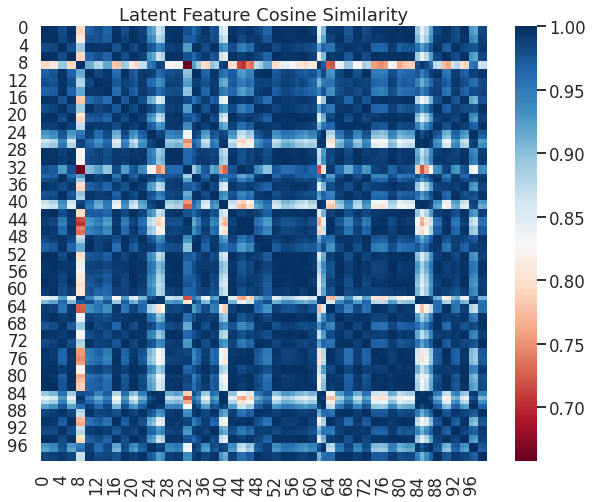

In [ ]:
# Cosine Similarity Visualization
plt.figure(figsize=(10,8))
plt.title('Latent Feature Cosine Similarity')
sns.heatmap(cosine_matrix[:100, :100], cmap='RdBu')
plt.show()

In [ ]:
# 기존 이미지 중 단일 샘플 추출
sample_idx = np.random.choice(np.arange(df.shape[0]),1)[0]
sample = data.loc[sample_idx,:].values.reshape(1,-1)
print('sample_idx :',sample_idx)

sample_idx : 15795


In [ ]:
# 기존 이미지 중 단일 샘플에 대한 코사인 유사도 계산식
sample_cosine_sim = cosine_similarity(sample, data)

print('sample_cosine_sim.shape :',sample_cosine_sim.shape)

sample_cosine_sim.shape : (1, 33170)


smp.shape : (64, 64, 3)
sample_cosine_sim.shape : (1, 246)



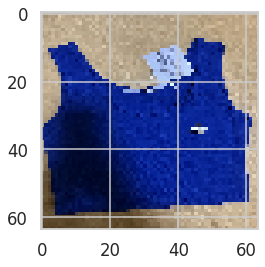

In [ ]:
# # 새로운 이미지 중 단일 샘플에 대한 코사인 유사도 계산식
# smp = New_image_preprocessing('sample.jpg')
# smp_emb = encoder.predict(np.reshape(smp,(1,64,64,3)))
# smp_comp = AVGpooling(smp_emb)
# print('smp.shape :',smp.shape)
# plt.imshow(smp)

# sample_cosine_sim = cosine_similarity(smp_comp, data)
# print('sample_cosine_sim.shape :',sample_cosine_sim.shape)
# print()

In [ ]:
# Define Sample Similarity DataFrame
df_cosine = pd.DataFrame(sample_cosine_sim.T, index=df.index, columns=['sample'])
print('df_cosine.shape :',df_cosine.shape)
df_cosine.head(4)

df_cosine.shape : (33170, 1)


,sample
0,0.755077
1,0.751851
2,0.756036
3,0.755103


In [ ]:
# Return Top10 Similar Items
top10_idx_cosine = df_cosine['sample'].nlargest(10).index
print('top10_idx_cosine :',top10_idx_cosine)
print(label[top10_idx_cosine].values)

top10_idx_cosine : Int64Index([15795, 25767, 25766, 15794, 32154, 28758, 23019, 6794, 26229,
            11971],
           dtype='int64')
['Item-Image\\1111077_F.jpg' 'Item-Image\\1127104_F.jpg'
 'Item-Image\\1127104_B.jpg' 'Item-Image\\1111077_B.jpg'
 'Item-Image\\1210797_B.jpg' 'Item-Image\\1203229_B.jpg'
 'Item-Image\\1123102_F.jpg' 'Item-Image\\1026062_B.jpg'
 'Item-Image\\1130030_F.jpg' 'Item-Image\\1104221_F.jpg']


Item-Image\1111077_F.jpg


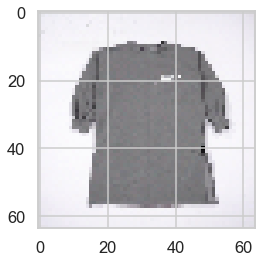

In [ ]:
# 기존 이미지 중 단일 샘플 이미지
print(df.loc[sample_idx,'label'])
_ = plt.imshow(img_set[sample_idx])

<Figure size 432x288 with 0 Axes>

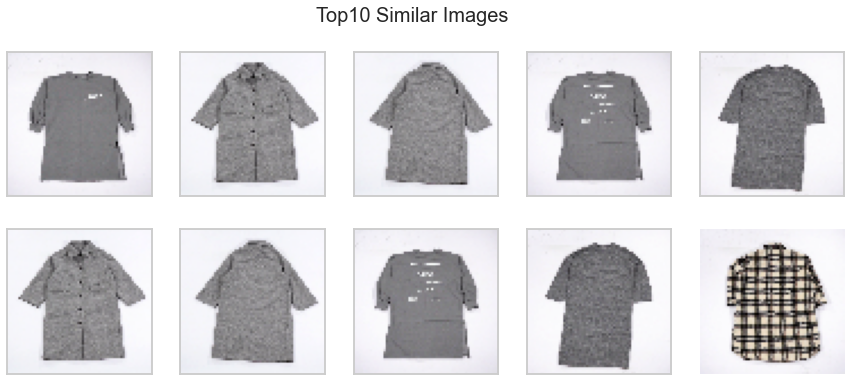

In [ ]:
# Top10 유사 이미지 시각화
top10_visualize(img_set,top10_idx_cosine)

### Euclidean Distance Calculation

In [ ]:
# Euclidean Distance Calculation
from sklearn.metrics.pairwise import euclidean_distances

ec_matrix = 1 / euclidean_distances(data, data)
print('ec_matrix.shape :',ec_matrix.shape)
ec_matrix[:4,:4]

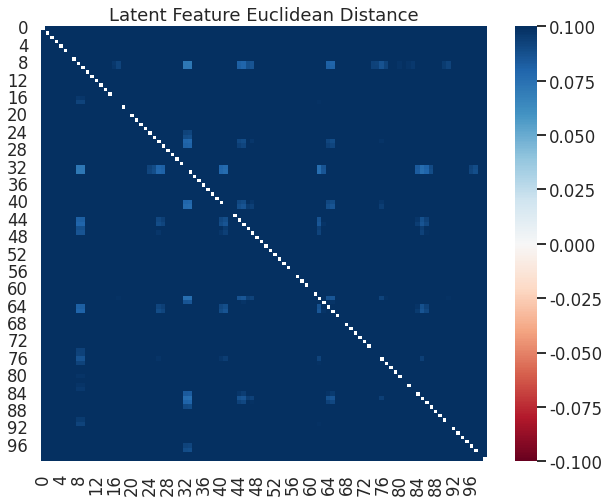

In [ ]:
# Euclidean Distance Visualization
plt.figure(figsize=(10,8))
plt.title('Latent Feature Euclidean Distance')
sns.heatmap(ec_matrix[:100, :100], cmap='RdBu')
plt.show()

In [ ]:
# 기존 이미지 중 단일 샘플에 대한 유클리디안 거리 계산식
sample_ec_distance = 1 / euclidean_distances(sample, data)

print('sample_ec_distance.shape :',sample_ec_distance.shape)

sample_ec_distance.shape : (1, 33170)


In [ ]:
# Define Sample Similarity DataFrame
df_ec = pd.DataFrame(sample_ec_distance.T, index=df.index, columns=['sample'])
print('df_ec.shape :',df_ec.shape)
df_ec.head(4)

df_ec.shape : (33170, 1)


,sample
0,0.093053
1,0.092740
2,0.093166
3,0.093034


In [ ]:
# Return Top10 Similar Items
top10_idx_ec = df_ec['sample'].nlargest(10).index
print('top10_idx_ec :',top10_idx_ec)
print(label[top10_idx_ec].values)

top10_idx_ec : Int64Index([15795, 25767, 25766, 15794, 6794, 28758, 23018, 12817, 32154,
            26228],
           dtype='int64')
['Item-Image\\1111077_F.jpg' 'Item-Image\\1127104_F.jpg'
 'Item-Image\\1127104_B.jpg' 'Item-Image\\1111077_B.jpg'
 'Item-Image\\1026062_B.jpg' 'Item-Image\\1203229_B.jpg'
 'Item-Image\\1123102_B.jpg' 'Item-Image\\1105384_F.jpg'
 'Item-Image\\1210797_B.jpg' 'Item-Image\\1130030_B.jpg']


Item-Image\1111077_F.jpg


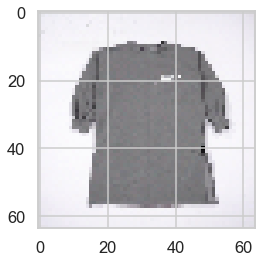

In [ ]:
# 기존 이미지 중 단일 샘플 이미지
print(df.loc[sample_idx,'label'])
_ = plt.imshow(img_set[sample_idx])

<Figure size 432x288 with 0 Axes>

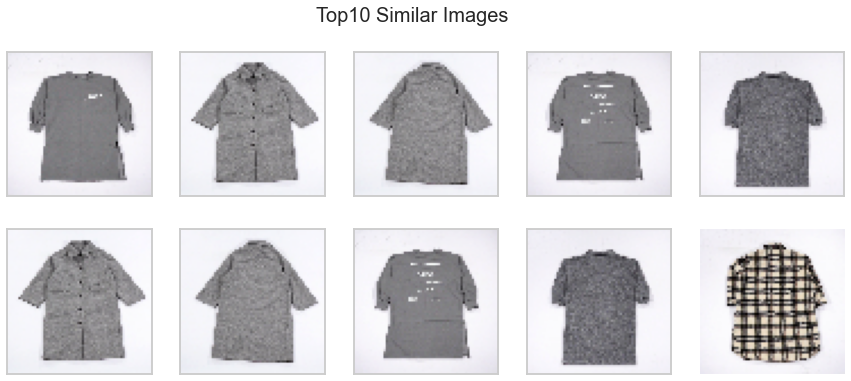

In [ ]:
# Top10 유사 이미지 시각화
top10_visualize(img_set,top10_idx_ec)

### Pearson Similarity

In [ ]:
# Pearson Similarity Computation
pearson_sim = np.corrcoef(data.to_numpy())
print('pearson_sim.shape :',pearson_sim.shape)
pearson_sim[:4,:4]

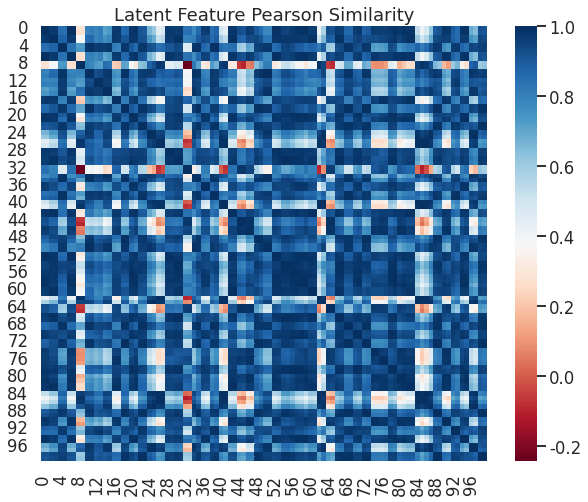

In [ ]:
# Pearson Similarity Visualization
plt.figure(figsize=(10,8))
plt.title('Latent Feature Pearson Similarity')
sns.heatmap(pearson_sim[:100, :100], cmap='RdBu')
plt.show()

In [ ]:
# 기존 이미지 중 단일 샘플에 대한 코사인 유사도 계산식
sample_pearson_sim = np.corrcoef(x=data.to_numpy(),y=sample)

print('sample_pearson_sim.shape :',sample_pearson_sim.shape)

In [ ]:
# Define Sample Similarity DataFrame
df_pearson = pd.DataFrame(sample_pearson_sim[-1,:-1], index=df.index, columns=['sample'])
print('df_pearson.shape :',df_pearson.shape)
df_pearson.head(4)

df_pearson.shape : (246, 1)


,sample
0,0.982054
1,0.979270
2,0.970446
3,0.972500


In [ ]:
# Return Top10 Similar Items
top10_idx_pearson = df_pearson['sample'].nlargest(10).index
print('top10_idx_pearson :',top10_idx_pearson)
print(label[top10_idx_pearson].values)

top10_idx_pearson : Int64Index([235, 234, 204, 139, 205, 79, 56, 186, 192, 193], dtype='int64')
['1209174_F.jpg' '1209174_B.jpg' '1127316_B.jpg' '1116482_F.jpg'
 '1127316_F.jpg' '1102128_F.jpg' '1027106_B.jpg' '1125302_B.jpg'
 '1126177_B.jpg' '1126177_F.jpg']


1209174_F.jpg


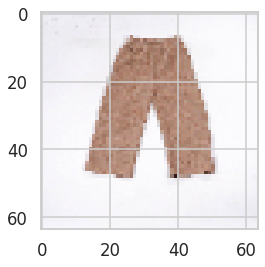

In [ ]:
# 기존 이미지 중 단일 샘플 이미지
print(df.loc[sample_idx,'label'])
_ = plt.imshow(img_set[sample_idx])

<Figure size 432x288 with 0 Axes>

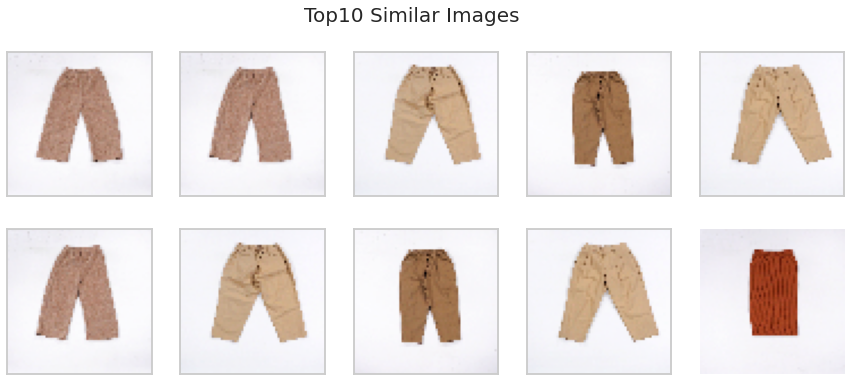

In [ ]:
# Top10 유사 이미지 시각화
top10_visualize(img_set,top10_idx_pearson)